# Project Description
The purpose of this notebook is to build NLP model to organize the abstracts of Randomized Controlled Trials into sections in order to make it faster and easier to read. The data is given in [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). Only 20k subset of the dataset is being used in this project.


Below is an example input abstract of a medical paper. For each sentence we are given a label, and we need to build a classification model that will predict target classes and help organize the abstract sentences into the given categories.
```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
```
> This project covers the replication of some of the ideas used in [Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) paper with some modifications to transfer learning model choice and improvements with some custom layers.

## Load libraries

In [ ]:
# Required tensorflow tools, libraries and modules
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.
from tensorflow.keras.utils import plot_model

# Data preprocessing and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import string
import re

# Sklearn metrics, text feature extraction and algorithms
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Auxiliary libraries for system interface, saving-loading model artifacts
import joblib
import os
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore') # ignores warnings about future updates, etc.


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import make_confusion_matrix, calculate_results

## Download the Data
Data has been made available by the authors at [github repo of the paper](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

In [ ]:
# check the files in PubMed_20k_RCT (explore the smaller subset)
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Explore the data 
with open('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt', 'r') as file:
  for row in range(16):
    print(file.readline())

###24293578

OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( 

In [ ]:
# Start our experiment with rct-20k-numbers_replaced_with_@ *dataseet*
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign' 
train_dir, dev_dir, test_dir = os.path.join(data_dir,'train.txt'), os.path.join(data_dir,'dev.txt'), os.path.join(data_dir,'test.txt')
train_dir, dev_dir, test_dir

('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

## Preprocessing Data

The above data exploration step showed that abstracts are determined by the id starting with ##, and there is a empty line seperating abstracts from each other. The lines for each abstract are represented as `category   sentence` string where category is given by the first word in a string. So, we need a preprocessing function that will take care of abstract ids and epty line, and seperate target and input (category and sentence) into x,y tensors. The preprocessed list will be as following

    '[{'line_num' : 0, 

    'target': 'background',

    'text' : 'Emotional eating is associated with overeating and the development of obesity .',

    'total_lines':15},
    
    {...}...]`

In [ ]:
# read in  [{},{},{}] format
def preprocess_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract lines
  """
  # read the lines from the text file
  with open(filename, 'r') as f:
    lines = f.readlines()

  abstract_lines = "" # create and empty abstract string
  abstract_samples = [] # create and empty list of abstracts
  
  for line in lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""  #reset the abstract 
    elif line.isspace(): #checks if the line is a new line
      abstract_lines_sep = abstract_lines.split('\n') # split abstract into strings of 'label sentence'
      abstract_len = len(abstract_lines_sep)
      # iterate through each line of abstract and build the dictionary
      for i, sentence in enumerate(abstract_lines_sep[:-1]):
        abstract_sample = {}
        target, sentence = sentence.split('\t')
        abstract_sample['line_number'] = i
        abstract_sample['target'] = target
        abstract_sample['text'] = sentence.lower()
        abstract_sample['total_lines'] = abstract_len
        abstract_samples.append(abstract_sample)
    else:
      abstract_lines += line
  return abstract_samples

In [ ]:
# preprocess train, validation, and test samples
train_samples = preprocess_with_line_numbers(train_dir)
valid_samples = preprocess_with_line_numbers(dev_dir)
test_samples = preprocess_with_line_numbers(test_dir)

# view the first abstract
train_samples[:3]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 13},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 13},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 13}]

## Explore data

In [ ]:
# convert list of dictionaries to pandas dataframe
train_data = pd.DataFrame(train_samples)
valid_data = pd.DataFrame(valid_samples)
test_data = pd.DataFrame(test_samples)

# get the position of line w.r.t total lines
train_data['line_pos'] = train_data.line_number/train_data.total_lines
valid_data['line_pos'] = valid_data.line_number/valid_data.total_lines
test_data['line_pos'] = test_data.line_number/test_data.total_lines

# view the training dataframe
train_data.head(5)

,line_number,target,text,total_lines,line_pos
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,13,0.000000
1,1,METHODS,a total of @ patients with primary knee oa wer...,13,0.076923
2,2,METHODS,outcome measures included pain reduction and i...,13,0.153846
3,3,METHODS,pain was assessed using the visual analog pain...,13,0.230769
4,4,METHODS,secondary outcome measures included the wester...,13,0.307692


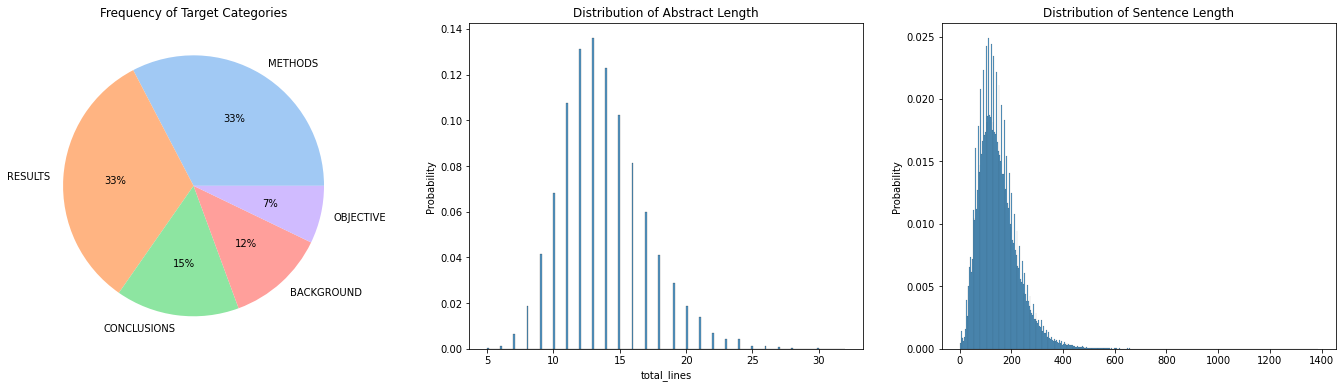

In [ ]:
# Explore data distribution
plt.figure(figsize = (24,6))
# plot target distribution pie chart
plt.subplot(1,3,1)  
# create pie chart
target_dist = (train_data['target'].value_counts()/train_data.shape[0]*100).astype('int') # get frequency data
colors = sns.color_palette('pastel')[0:5]   # define Seaborn color palette to use
plt.pie(target_dist.values, labels = target_dist.index,  colors = colors, autopct='%.0f%%')
plt.title('Frequency of Target Categories')
# create histogram of abstract length
plt.subplot(1,3,2)  
sns.histplot(train_data['total_lines'], stat = 'probability' )
plt.title('Distribution of Abstract Length')
# create histogram of sentence length
plt.subplot(1,3,3)  
sns.histplot(train_data['text'].str.len().values, stat = 'probability' )
plt.title('Distribution of Sentence Length')
plt.show()

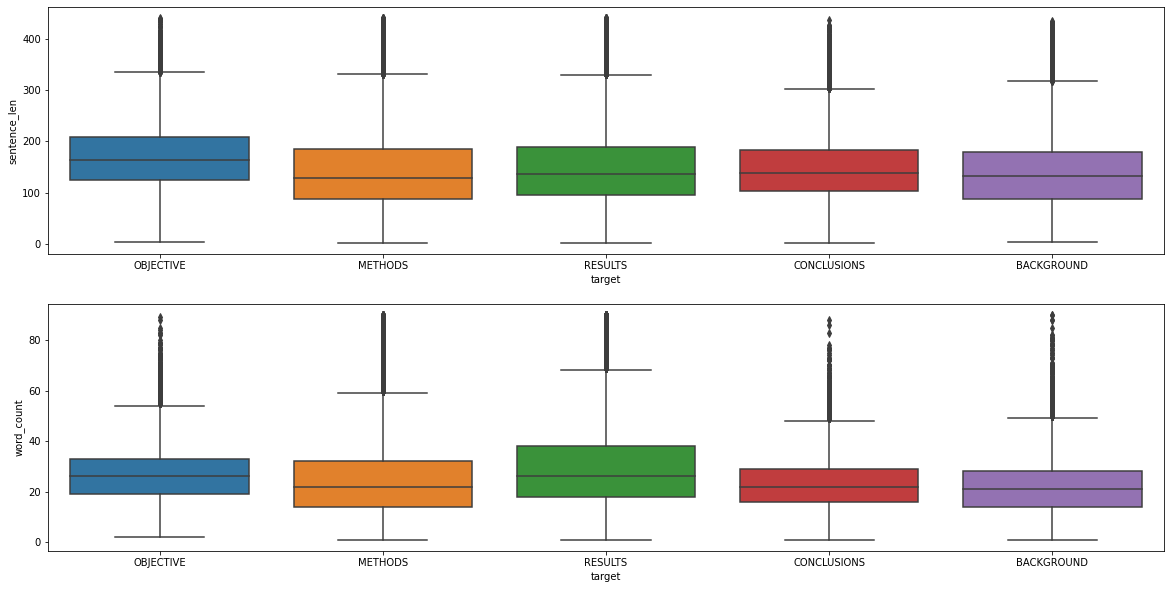

In [ ]:
# Create sentence length and word count columns for each sentence in the train data
target_df = train_data[['target','text']]
target_df['sentence_len'] = target_df.text.str.len()
target_df['word_count'] = [len(sentence.split()) for sentence in target_df.text.values]
# Create a box plot of Sentence length by target category
plt.figure(figsize = (20, 10))
for i, col in enumerate(['sentence_len', 'word_count']):
  plt.subplot(2,1,i+1)
  non_outliers = target_df[col] < np.percentile(target_df[col].values, [99.5])[0]  # ignore outliers (< 99.5 percentile)
  sns.boxplot(data = target_df[non_outliers], x = 'target', y = col)
plt.show()


Bacgrounds seem to be shortest since it is not very significant part of the research. And objective and conclusions are also shorter compared to methods and results, because research abstracts needs to be concise explaining research question and contributions in short but clear way. 

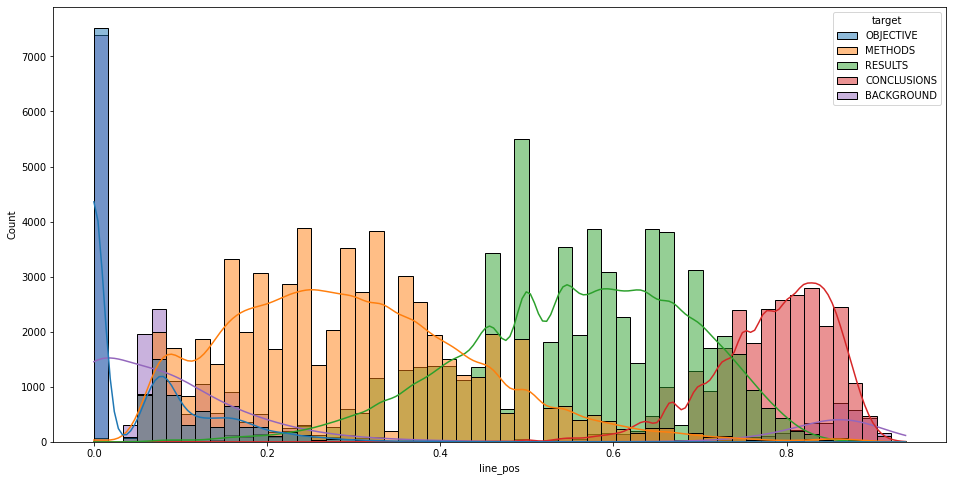

In [ ]:
# Plot the distribution (using kernel density estimation) of relative position of sentences (line_number / total_lines)
plt.figure(figsize = (16,8))
sns.histplot(data = train_data, x = 'line_pos', hue = 'target', kde = True)
plt.show()

In [ ]:
# Check the common location for Background sentences
print((train_data[train_data.target == 'BACKGROUND']['line_number']<2).sum()/len(train_data[train_data.target == 'BACKGROUND'])) 
# Check the common location for Objective sentences
print((train_data[train_data.target == 'OBJECTIVE']['line_number']<2).sum()/len(train_data[train_data.target == 'OBJECTIVE']))

0.6119114465871957
0.7964448298287449


Objective and background are generally introduced in the earlier sentences of an abstract. There are significantly less objective and background sentences compared to other sentence categories. Differentiating these two is going to be the main challenge of this project. Based on the above information, nearly 60% of bacground sentences and 70% of objective sentences are located within first 3 sentences.

It will be easier to identify methods, results and conclusion sentences, since these sentences are usually characterized by research specific method names, numerical results, and conclusive phrases, respectively, and their location does not overlap too much with each other.

In [ ]:
# Create a statistics table of location of target categories within the abstract
# Define functions to calculate percentile values
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q10(x):
    return x.quantile(0.10)
def q90(x):
    return x.quantile(0.90)
print('Sentence order (top 5 most frequent line number) by target category:')
train_data[['target', 'line_pos']].groupby('target').agg(['mean', 'median', 'std', q10, q25, q75, q90])

Sentence order (top 5 most frequent line number) by target category:


line_pos                                                    \
                 mean    median       std       q10       q25       q75   
target                                                                    
BACKGROUND   0.193119  0.076923  0.289042  0.000000  0.000000  0.181818   
CONCLUSIONS  0.782850  0.800000  0.073928  0.692308  0.750000  0.833333   
METHODS      0.297822  0.285714  0.143127  0.125000  0.187500  0.384615   
OBJECTIVE    0.057115  0.000000  0.077591  0.000000  0.000000  0.090909   
RESULTS      0.557483  0.571429  0.131778  0.384615  0.466667  0.666667   

                       
                  q90  
target                 
BACKGROUND   0.846154  
CONCLUSIONS  0.857143  
METHODS      0.500000  
OBJECTIVE    0.166667  
RESULTS      0.722222

All target categories except background usually follow a standard order of `objective->methods->results->conclusion`.

## Create Numeric Labels

We will use label/one-hot encoding of target classes depending on the algorithm choice.

In [ ]:
# create a list of class names and a dictionary for mapping to numeric label
class_names = list(train_data['target'].value_counts().index)
target_map = {name:i for i,name in enumerate(class_names)}
print(f'Class names: {class_names}\n')
print(f'Target map: {target_map}\n')

# map target values to numeric labels 
train_labels = train_data['target'].replace(target_map).values
valid_labels = valid_data['target'].replace(target_map).values
test_labels = test_data['target'].replace(target_map).values

# convert labels to one-hot vectors
train_target = tf.keras.utils.to_categorical(train_labels, num_classes = 5)
valid_target = tf.keras.utils.to_categorical(valid_labels, num_classes = 5)
test_target = tf.keras.utils.to_categorical(test_labels, num_classes = 5)

# view sample numeric labels
sample_targets = train_data.target.values[:5]
sample_numeric = train_labels[:5]
sample_one_hot = train_target[:5]
print(f'\nTarget classes\n {sample_targets}\n\nLabel encoded\n {sample_numeric}')
print(f'\nOne-hot-encoded \n{sample_one_hot}')


Class names: ['METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'OBJECTIVE']

Target map: {'METHODS': 0, 'RESULTS': 1, 'CONCLUSIONS': 2, 'BACKGROUND': 3, 'OBJECTIVE': 4}


Target classes
 ['OBJECTIVE' 'METHODS' 'METHODS' 'METHODS' 'METHODS']

Label encoded
 [4 0 0 0 0]

One-hot-encoded 
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Baseline Multinomial Naive Bayes Classifier

Experiment 0 - Baseline model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In this model, text is converted to numbers using Tf–idf term weighting, then multinomial bayes classifier assigns sentences to one of 5 classes. We carry out these two steps in sklearn pipeline.

In [ ]:
# Create stopwords
my_stop_words = text.ENGLISH_STOP_WORDS

# Create a pipeline
model_0 = Pipeline([
    # convert our abstract sentences to numbers using the TF-IDF 
  ("tf-idf", TfidfVectorizer(stop_words=set(my_stop_words),max_features=30000, ngram_range=(1, 2))),
   # classify the sentences using the MultinomialNB aglorithm
   ("clf", MultinomialNB(alpha = 1))
])
         
# Fit the pipeline to the training data
model_0.fit(X=train_data['text'], 
            y=train_labels)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(max_features=30000, ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', 'anywhere', ...})),
                ('clf', MultinomialNB(alpha=1))])

In [ ]:
# predict labels 
test_pred = model_0.predict(test_data['text'])

# get performance metrics for the baseline model
model_0_results = calculate_results(test_labels, test_pred)
model_0_results

{'accuracy': 73.49261655881864,
 'precision': 0.7275978237183811,
 'recall': 0.7349261655881865,
 'f1': 0.7261892391839947}

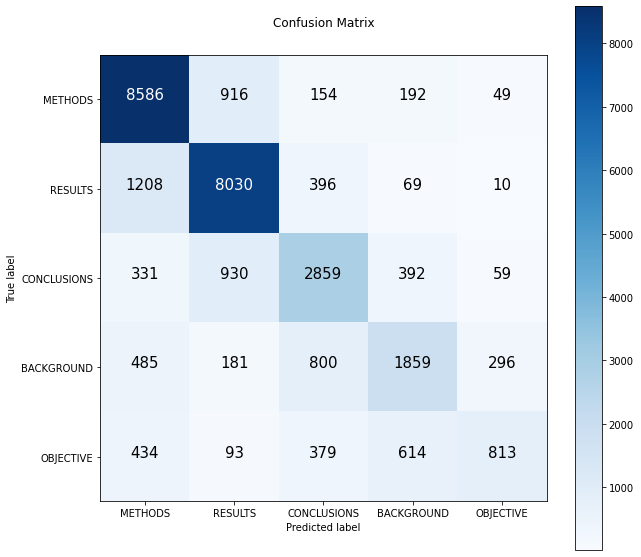

In [ ]:
# Draw confusion matrix
make_confusion_matrix(test_labels, test_pred, classes = class_names)

As expected, objective and background sentences are hardest to predict after. Overall, the performance is pretty bad.

# Sequence + Pretrained Attention Models

In [ ]:
# convert input text columns into a list
train_text = train_data['text'].values.tolist()
valid_text = valid_data['text'].values.tolist()
test_text = test_data['text'].values.tolist()
print(f'The number of sentences in train, validation, and test sets is {len(train_text), len(valid_text), len(test_text)}, respectively')

The number of sentences in train, validation, and test sets is (180040, 30212, 30135), respectively


## Model 1: Recurrent Neural Net with token embeddings
Here we build our first deep learning model. All of our deep models will follow a similar structure:

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

The main component we'll be changing throughout the notebook is the Layers component.

The first model we are going to build is a 1-dimensional Convolutional Neural Network.

### Preparing data
First, we convert our data into Tensorflow Dataset, then, we create vectorization and embedding layers for sequence models.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

Before converting our sentences into numerical sequences, we want all sequences to have a consistent length. For this, we are going to explore some statistics for the lenght of sentences.



In [ ]:
print(f'Sequence length percentiles (10, 30, 50, 70, 90) are {tuple(np.percentile([len(sequence.split()) for sequence in train_text], [10, 30, 50, 70, 90]))}')

Sequence length percentiles (10, 30, 50, 70, 90) are (11.0, 17.0, 23.0, 31.0, 45.0)


It seems that the median lenght of the sentence is 23, and it is less than 45 for 90% of the sequences.

### Create text vectorizer

We use the TextVectorization layer to convert text into numbers.

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. However, we will use smaller number - 30,000 - to reduce the number of trainable parameters for embedding layer. And since a sentence length of 31 covers 70% of the training sentences, we'll use that as our output_sequence_length parameter.

In [ ]:
# Create text vectorizer
max_tokens = 30_000
max_sequence_length = 31
text_vectorizer = layers.TextVectorization(max_tokens = max_tokens,                       # number of words in vocabulary
                                    output_sequence_length=max_sequence_length,    # desired output length of vectorized sequences
                                    pad_to_max_tokens = True,
                                    name = 'text_vectorizer')                      # this is to ensure consistent sequence length
text_vectorizer.adapt(train_text)

In [ ]:
# Test out text vectorizer
target_sentence = random.choice(train_text)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
an assessor-blinded randomized controlled trial was conducted among @ participants with a dsm-iv-tr diagnosis of primary ptsd .

Length of text: 18

Vectorized text:
[[  26 6834   29  106   32   10  198  116   60    7    8 7376  536    4
    56 1171    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


In [ ]:
# How many words in our training vocabulary?
text_vocab_20 = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vocab_20)}"), 
print(f"Most common words in the vocabulary: {text_vocab_20[:5]}")
print(f"Least common words in the vocabulary: {text_vocab_20[-5:]}")

Number of words in vocabulary: 30000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['mpfc', 'mpdac', 'moxifloxacincontaining', 'movers', 'movementsweek']


In [ ]:
# Create an inverse vocabulary
inverse_vocab_20 = {i:word for i, word in enumerate(text_vocab_20)}
# Convert vectorized text into a sentence
print(f'Original sentence: \n\t{target_sentence}')
print(f"\n\nDecoded vectorized sentence\n\t{''.join([inverse_vocab_20[token]+' ' for token in text_vectorizer(target_sentence).numpy()])}")

Original sentence: 
	an assessor-blinded randomized controlled trial was conducted among @ participants with a dsm-iv-tr diagnosis of primary ptsd .


Decoded vectorized sentence
	an assessorblinded randomized controlled trial was conducted among participants with a dsmivtr diagnosis of primary ptsd                


### Create custom text embedding
The token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding where each word is represented by a vector such that similar words have similar vector representation (e.g., king - man + woman = queen). 

As the model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

The main parameters of the embedding layer are the input dim (vocab size) and output dim (embedding vector length) , and max input length (max sequence length).

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = max_tokens, # length of vocabulary
                               output_dim = 256,       # Note: This is the main dimension affecting the number of trainable parameters
                               mask_zero = True, 
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
an assessor-blinded randomized controlled trial was conducted among @ participants with a dsm-iv-tr diagnosis of primary ptsd .

Sentence after vectorization (before embedding):
[[  26 6834   29  106   32   10  198  116   60    7    8 7376  536    4
    56 1171    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]

Sentence after embedding:
[[[-0.02888619 -0.03856571 -0.04719892 ... -0.00212596  0.01339102
    0.04252826]
  [ 0.0035943  -0.04514241 -0.03198235 ... -0.02215425  0.01619228
    0.04645107]
  [ 0.02573747 -0.04185289 -0.03183478 ... -0.00948446 -0.04504157
   -0.01531164]
  ...
  [-0.04245117  0.03671554  0.01750456 ...  0.03166676 -0.01444143
   -0.03690075]
  [-0.04245117  0.03671554  0.01750456 ...  0.03166676 -0.01444143
   -0.03690075]
  [-0.04245117  0.03671554  0.01750456 ...  0.03166676 -0.01444143
   -0.03690075]]]

Embedded sentence shape: (1, 31, 256)


### Create datasets 


We will use tf.data Api for input pipelines which loads our data onto the GPU as fast as possible, in turn leading to faster training time. 

The main step is to turn it into a batched PrefetchDataset of batches.

We also use positional data in addition to textual data. The positional encoding is given by `line_pos = line_number / total_lines` which represents the relative position of a sentence in an abstract.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# build tf dataset
train_ds = tf.data.Dataset.from_tensor_slices(((train_text, train_data['line_pos'].values[..., None]), train_target))
valid_ds = tf.data.Dataset.from_tensor_slices(((valid_text, valid_data['line_pos'].values[..., None]), valid_target))
test_ds = tf.data.Dataset.from_tensor_slices(((test_text, test_data['line_pos'].values[..., None]), test_target))

# convert datasets into batched prefetched datasets
train_dataset = train_ds.shuffle(10000).batch(batch_size).prefetch(AUTOTUNE)
valid_dataset = valid_ds.batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_ds.batch(batch_size).prefetch(AUTOTUNE)

for (text, pos), labels in train_dataset.take(1):
  print(text.shape)    # batch of sequences
  print(labels.shape)  # batch of one-hot encoded labels

(32,)
(32, 5)


In [ ]:
# Create 1D convolutional model to process sequences
text_inputs = layers.Input(shape=(1,), dtype=tf.string) # create layers for the text input
text_vectors = text_vectorizer(text_inputs)  # vectorize text inputs
token_embeddings = token_embed(text_vectors)  # create embedding
x = layers.Bidirectional(layers.LSTM(128, 'tanh', return_sequences = True))(token_embeddings)
x = layers.Conv1D(64, 5, activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, 'relu')(x)
pos_inputs = layers.Input(shape = [1,])  # create layers for the positional input
y = layers.Dense(32,'relu')(pos_inputs)
z = layers.concatenate([x,y]) # combine dense outputs of two input streams
outputs = layers.Dense(5, activation="softmax")(z)  # finds the probabilities of each category
model_1 = tf.keras.Model([text_inputs,pos_inputs], outputs)  # combine the layers into a keras model

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorizer (TextVectoriza  (None, 31)          0           ['input_10[0][0]']               
 tion)                                                                                            
                                                                                                  
 token_embedding (Embedding)    (None, 31, 256)      7680000     ['text_vectorizer[5][0]']        
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 31, 256)     394240      ['token_embedding[5][0]']  

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=1,
                              validation_data=valid_dataset)

5627/5627 [==============================] - 131s 21ms/step - loss: 0.4113 - accuracy: 0.8484 - val_loss: 0.3163 - val_accuracy: 0.8828


942/942 [==============================] - 7s 5ms/step


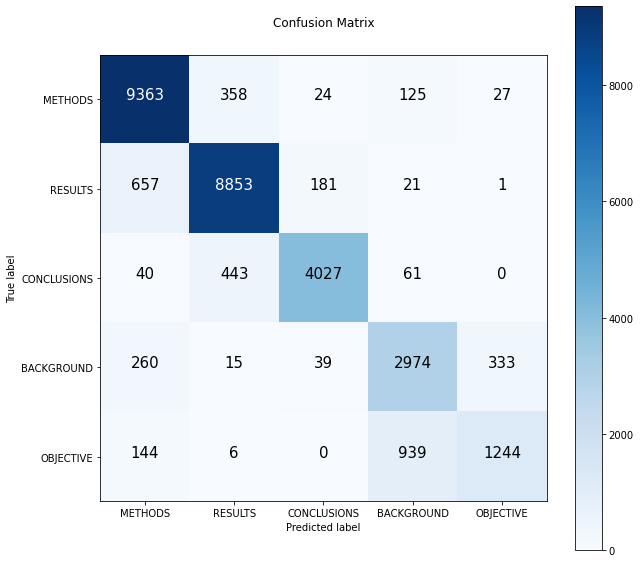

In [ ]:
# Visualise model_1 results
test_preds = tf.argmax(model_1.predict(test_dataset), axis = 1)
make_confusion_matrix(test_labels, test_preds, classes = class_names)

In [ ]:
# Calculate main metrics for model 1
model_1_results = calculate_results(test_labels, test_preds)
print(model_1_results)
print(classification_report(test_labels, test_preds))

{'accuracy': 87.80819644931142, 'precision': 0.878558068208608, 'recall': 0.8780819644931143, 'f1': 0.8758092442590242}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      9897
           1       0.92      0.91      0.91      9713
           2       0.94      0.88      0.91      4571
           3       0.72      0.82      0.77      3621
           4       0.78      0.53      0.63      2333

    accuracy                           0.88     30135
   macro avg       0.85      0.82      0.83     30135
weighted avg       0.88      0.88      0.88     30135



There is a 10% improvement in the accuracy score compared to the baseline model. However, we are still not able to differentiate objective sentences from background sentences very vell.

## Model 2: Feature extraction with pretrained (with Attention mechanism) token embeddings

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.

>`🔑 Note: We do not use GloVe embeddings as per the paper, since we're working with TensorFlow, and GloVe embeddings aren't available at TensorFlow Hub.

We use embeddings from [BERT](https://tfhub.dev/google/experts/bert/pubmed/2) architecture pretrained from scratch  on MEDLINE/PubMed.

For this we will load a preprocessing and bert encoder from Tensorflow Hub and convert them to keras layers.

The model structure will look like:

>`Inputs (string) -> Preprocessing layer --> Bert Encoder -> Dense Layer -> Output (prediction probabilities)`




### Load Bert PubMed Model and Preprocessor

In [ ]:
# Source https://tfhub.dev/google/experts/bert/pubmed/2
# Define sample sentences to feed into the model
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]
print(f'Original input shape:\t{np.array(sentences).shape}')

# Load the BERT encoder and preprocessing models and convert them into keras layers
preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                                        trainable=False,
                                        name="preprocess")
bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                       trainable=False,
                       name="bert")

# Convert the sample sentences to bert inputs
bert_inputs = preprocess(sentences)
print(f"Preprocessed input shape: \t{bert_inputs['input_word_ids'].shape}")
# Feed the inputs to the model to get the pooled and sequence outputs
bert_outputs = bert(bert_inputs, training=False)
print(f"Pooled bert output shape: \t{bert_outputs['pooled_output'].shape}")


Original input shape:	(5,)
Preprocessed input shape: 	(5, 128)
Pooled bert output shape: 	(5, 768)


### Build Transfer Learning Model

In [ ]:
# Build a model with with pretrained Bert embeddings
inputs = layers.Input(shape=[], dtype=tf.string)
x = preprocess(inputs) # preprocess and vectorization layer
x = bert(x)  # non-trainable pretrained bert layer
x = layers.Dense(128, 'relu')(x['pooled_output']) # trainable dense layer on top of pretrained embeddings
inputs1 = layers.Input(shape=[1,])
x1 = layers.Dense(32, 'relu')(inputs1)
x = layers.concatenate([x,x1])
outputs = layers.Dense(5, activation="softmax")(x)  # output layer

# combine layers into keras Model
model_2 = tf.keras.Model(inputs=[inputs,inputs1],
                        outputs=outputs)
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# Fit feature extractor model for 2 epochs
model_2.fit(train_dataset,
            epochs=1,
            validation_data=valid_dataset)

5627/5627 [==============================] - 2042s 361ms/step - loss: 0.3418 - accuracy: 0.8758 - val_loss: 0.2957 - val_accuracy: 0.8912


In [ ]:
# Calculate test metrics for model_2
test_preds = tf.argmax(model_2.predict(test_dataset),1)
model_2_results = calculate_results(test_labels, test_preds)
print(model_2_results)
print(classification_report(test_labels, test_preds))

942/942 [==============================] - 289s 306ms/step
{'accuracy': 88.68757259001161, 'precision': 0.8931690013908782, 'recall': 0.8868757259001161, 'f1': 0.8826460844949848}
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      9897
           1       0.91      0.94      0.92      9713
           2       0.97      0.86      0.91      4571
           3       0.69      0.90      0.78      3621
           4       0.85      0.44      0.58      2333

    accuracy                           0.89     30135
   macro avg       0.87      0.82      0.83     30135
weighted avg       0.89      0.89      0.88     30135



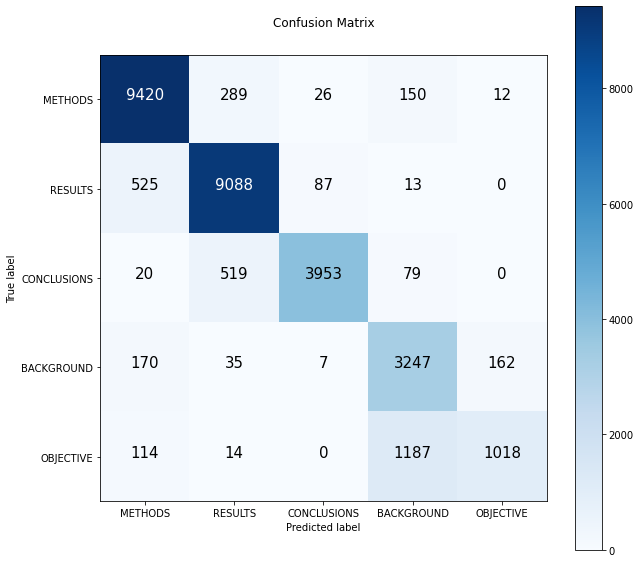

In [ ]:
# Create confusion matrix
make_confusion_matrix(test_labels, test_preds, classes = class_names)

Overall performance is much better than the model 1, but it performs worse on Objective sentences. It can detect only 40 percent of objective sentences, and predicts most of the remaining as background sentence.


## Model 3: Conv1D with character Embeddings

### Creating a character-level tokenizer

The Neural Networks for Joint Sentence Classification in [Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) paper uses a hybrid of token and character embeddings.

In models 1 and 2, we have tried a custom token embedding and a pretrained token embedding, and in model 3, we are going to use character embedding.

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
print(f"'Sample text' --> '{split_chars('Sample text')}'")

'Sample text' --> 'S a m p l e   t e x t'


In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_text]
val_chars = [split_chars(sentence) for sentence in valid_text]
test_chars = [split_chars(sentence) for sentence in test_text]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile([len(sentence) for sentence in train_text], 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
     
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
random_train_chars = random.choice(train_chars)
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p y r i f o r m   s i n u s   l o c a l i z a t i o n - a s s i s t e d   b l i n d   o r o t r a c h e a l   i n t u b a t i o n   w a s   s h o w n   t o   b e   m o r e   e f f e c t i v e   t h a n   c o n v e n t i o n a l   l a r y n g o s c o p i c   o r o t r a c h e a l   i n t u b a t i o n   i n   t e r m s   o f   s u c c e s s   r a t e   ,   i n t u b a t i o n   t i m e   ,   a n d   p o s t o p e r a t i v e   c o m p l i c a t i o n   r a t e   .

Embedded chars (after vectorization and embedding):
[[[-0.01825935  0.01104826  0.03294636 ...  0.04516157  0.0164954
   -0.00262884]
  [-0.04971379 -0.0472456   0.0026673  ...  0.00553247  0.03682283
   -0.0029126 ]
  [ 0.03740621 -0.02262765 -0.00514733 ... -0.01945049 -0.02902082
   -0.04694089]
  ...
  [-0.00280442 -0.03381069  0.04696467 ...  0.04638871  0.00659662
   -0.04962163]
  [-0.00280442 -0.03381069  0.04696467 ...  0.04638871  0.00659662
   -0.04962163]
  [-0.

### Build and Train Model

In [ ]:
# Make Conv1D on chars only
inputs_text = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs_text)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)

inputs_pos = layers.Input(shape = [1,])
y = layers.Dense(16, 'relu')(inputs_pos)
z = layers.concatenate([x,y])
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=[inputs_text,inputs_pos],
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_16[0][0]']               
 tion)                                                                                            
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      1750        ['char_vectorizer[2][0]']        
                                                                                                  
 conv1d_8 (Conv1D)              (None, 290, 64)      8064        ['cha

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices(((train_chars,train_data['line_pos'].values[..., None]), train_target)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices(((val_chars,valid_data['line_pos'].values[..., None]), valid_target)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices(((test_chars,test_data['line_pos'].values[..., None,]), test_target)).batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              validation_data=val_char_dataset)

In [ ]:
# Evaluate the model on test dataset
test_preds = tf.argmax(model_3.predict(test_char_dataset),1)
model_3_results = calculate_results(test_labels, test_preds)
print(model_3_results)
print(classification_report(test_labels, test_preds))

942/942 [==============================] - 2s 2ms/step
{'accuracy': 73.04795088767214, 'precision': 0.730756057981532, 'recall': 0.7304795088767214, 'f1': 0.7235066895895993}
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      9897
           1       0.72      0.89      0.80      9713
           2       0.65      0.55      0.60      4571
           3       0.56      0.54      0.55      3621
           4       0.74      0.42      0.53      2333

    accuracy                           0.73     30135
   macro avg       0.70      0.64      0.66     30135
weighted avg       0.73      0.73      0.72     30135



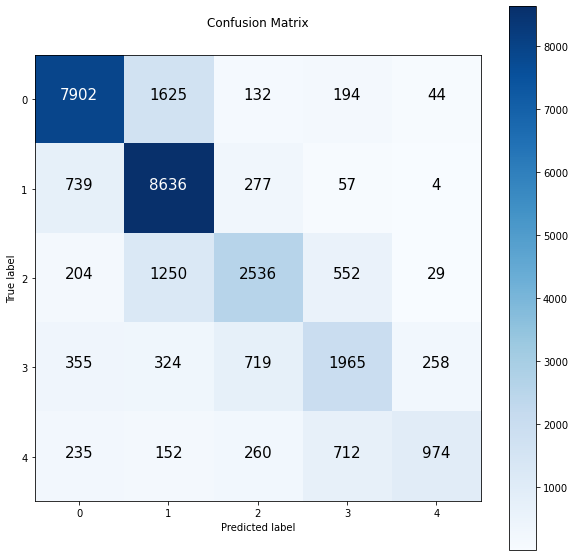

In [ ]:
# Generate confusion matrix
make_confusion_matrix(test_labels, test_preds)

## Model 4 : Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

As given in figure 1 of paper [Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf), we will build a hybrid model with character and token embeddings.
To combine the embeddings we will use `concatenate` layer to stack dense outputs of the embeddings.

### Prepare Data

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices(((train_text, train_chars), train_target)) 
val_char_token_data = tf.data.Dataset.from_tensor_slices(((valid_text, val_chars), valid_target))
test_char_token_data = tf.data.Dataset.from_tensor_slices(((test_text, test_chars), test_target)) # make data

# Prefetch and batch train data
train_char_token_dataset = train_char_token_data.batch(32).prefetch(tf.data.AUTOTUNE) 
val_char_token_dataset = val_char_token_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

### Build and Train a Hybrid Model

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
preprocessed_inputs = preprocess(token_inputs)
token_embeddings = bert(preprocessed_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings['pooled_output'])
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
preprocess (KerasLayer)         {'input_word_ids': ( 0           token_input[0][0]                
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________

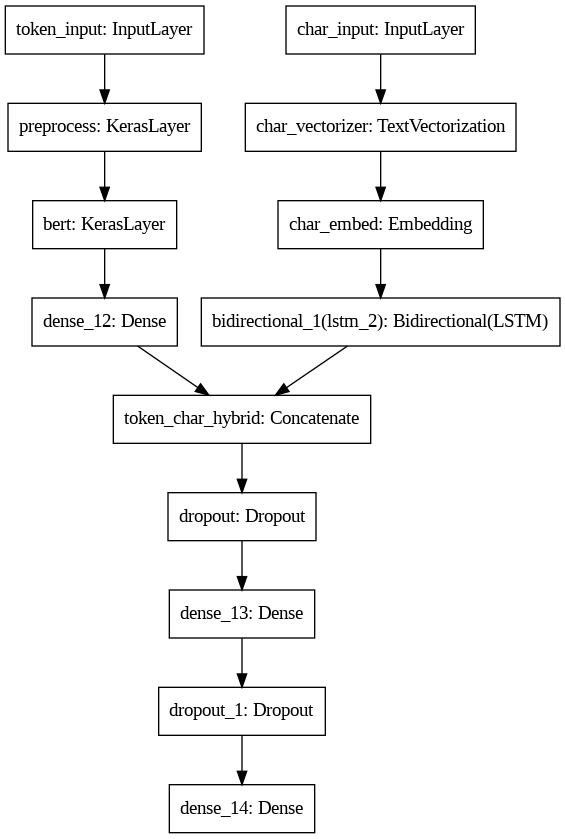

In [ ]:
# Plot hybrid token and character model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, 
                              epochs=2,
                              validation_data=val_char_token_dataset)

5627/5627 [==============================] - 2126s 378ms/step - loss: 0.4692 - accuracy: 0.8387 - val_loss: 0.4277 - val_accuracy: 0.8525


In [ ]:
# evaluate the model on test data
test_preds = tf.argmax(model_4.predict(test_char_token_dataset),1)
model_4_results = calculate_results(test_labels, test_preds)
print(model_4_results)
print(classification_report(test_labels, test_preds))

{'accuracy': 84.44997511199603, 'precision': 0.8443085291751432, 'recall': 0.8444997511199602, 'f1': 0.8419127585992977}
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      9897
           1       0.85      0.93      0.89      9713
           2       0.85      0.78      0.81      4571
           3       0.69      0.75      0.72      3621
           4       0.76      0.53      0.63      2333

    accuracy                           0.84     30135
   macro avg       0.81      0.78      0.79     30135
weighted avg       0.84      0.84      0.84     30135



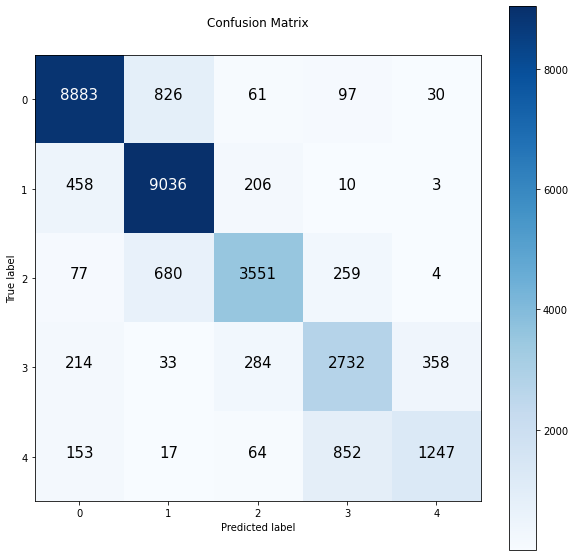

In [ ]:
# Create confusion matrix 
make_confusion_matrix(test_labels, test_preds)


## Model 5: Character + Token + Positional Embeddings

For this experiment, we will use line number and total lines, and relative line position columns in addition to textual data. Target categories usually follows a standard order, and longer abstracts is more likely to include more background sentences compared to shorter ones.

In addition to this, we are also building word2vec model to learn word embeddings using context words. We will theese use pretrained embeddings in our tridbid hybrid model. 

The model will have three input streams, and will concatenate embeddings into single tensor.

1. Input layer (Origonal sequences) -->  tokenizer --> word2vec embeddings --> Bidirectional LSTM --> Dense layer
2. Input layer (Origonal sequences) --> Bert preprocessing layer --> Bert encoding layer --> Dense layer
3. Input layer (Char data) --> Char tokenizer --> char embedding --> Bidirectional LSTM
4. Input layer (Positional) --> Dense layer


In [ ]:
# Show line_number and total_lines columns
train_data.head(5)

,line_number,target,text,total_lines,line_pos
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,13,0.000000
1,1,METHODS,a total of @ patients with primary knee oa wer...,13,0.076923
2,2,METHODS,outcome measures included pain reduction and i...,13,0.153846
3,3,METHODS,pain was assessed using the visual analog pain...,13,0.230769
4,4,METHODS,secondary outcome measures included the wester...,13,0.307692


### Generate positional data

In [ ]:
# one-hot-encoded tensors of our "line_number" column 
depth = 20
train_line_numbers = tf.one_hot(train_data["line_number"].to_numpy(), depth=depth)
val_line_numbers = tf.one_hot(valid_data["line_number"].to_numpy(), depth=depth)
test_line_numbers = tf.one_hot(test_data["line_number"].to_numpy(), depth=depth)
print(train_line_numbers.shape, val_line_numbers.shape)

# one-hot-encoded tensors of our "total_lines" column 
train_total_lines = tf.one_hot(train_data["line_number"].to_numpy(), depth=depth)
val_total_lines = tf.one_hot(valid_data["line_number"].to_numpy(), depth=depth)
test_total_lines = tf.one_hot(test_data["line_number"].to_numpy(), depth=depth)
print(train_total_lines.shape, val_total_lines.shape)

# get relative positional data
train_rel_pos = train_data['line_pos'].values[..., None]
val_rel_pos = valid_data['line_pos'].values[..., None]
test_rel_pos = test_data['line_pos'].values[..., None]
print(train_rel_pos.shape, val_rel_pos.shape)

# combine positional data into single tensor
train_position = tf.concat([train_line_numbers, train_total_lines, train_rel_pos],axis = 1)
val_position = tf.concat([val_line_numbers, val_total_lines, val_rel_pos],axis = 1)
test_position = tf.concat([test_line_numbers, test_total_lines, test_rel_pos],axis = 1)
print(train_position.shape, val_position.shape, test_position.shape)

(180040, 20) (30212, 20)
(180040, 20) (30212, 20)
(180040, 1) (30212, 1)
(180040, 41) (30212, 41) (30135, 41)


### Word2Vec model with Skipgrams to generate custom embeddings
Here, we use the Tensorflow [word2vec instructions](https://www.tensorflow.org/tutorials/text/word2vec) to learn embeddings of our pubmed data. 

We first build a vectorizer, and then generate skip-gram pairs with negative sampling, we get ((target, context), label) dataset where label indicates the word is in the context of target word.


In [ ]:
# Build and adapt the vectorizer
text_sequences = train_text + valid_text
VOCAB_SIZE = 30000 # smaller vocab size than the one used in the paper
MAX_SEQUENCE_LENGTH = 31 # I chose 70th percentile value for the max_len as before


vectorizer = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE,
                                               standardize='lower_and_strip_punctuation',
                                               pad_to_max_tokens = True,
                                               output_sequence_length = MAX_SEQUENCE_LENGTH
                                               )
vectorizer.adapt(text_sequences)

#### Create a function to generate skipgram pairs and labels

In [ ]:
# # Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(vectorizer = vectorizer, sequences = text_sequences, window_size = 1, num_ns = 2, vocab_size = VOCAB_SIZE, seed = 42):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):
    # vectorize the sequence
    sequence = vectorizer(sequence)[:len(sequence.split())].numpy()
    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

#### Create Custom Word2Vec model via subclassing 

In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=2+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

#### Train Word2Vec Model

In [ ]:
# prepare data for word2vec model
BATCH_SIZE = 1024
BUFFER_SIZE = 100000
targets, context, labels = generate_training_data(vectorizer = vectorizer, sequences = text_sequences) # generate skipgrams
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels)) # create tf.Data dataset
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Build and train the model 
embedding_dim = 256
epochs = 20
word2vec = Word2Vec(VOCAB_SIZE, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

word2vec.fit(dataset, epochs=epochs, callbacks=[tensorboard_callback])

# save the weights
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
joblib.dump(weights, 'embeddings.pkl')

### Build Tridbrid model

In [ ]:
# load word2vec embeddings and build the embedding layer
weights = joblib.load('embeddings.pkl') # load weights
word2vec_embed = tf.keras.layers.Embedding(input_dim=30000,
                            output_dim=256,
                            input_length=31,
                            trainable=False,
                            name = 'word2vec_embed')
word2vec_embed.build((None, ))
word2vec_embed.set_weights([weights])

In [ ]:
def build_model_5():
    # 1. Set up word inputs/model with word2vec and bert embeddings
    token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
    x1 = vectorizer(token_inputs)
    x1 = word2vec_embed(x1) # word2vec embedding
    x1 = layers.Bidirectional(layers.LSTM(128, 'tanh'))(x1)
    x1 = layers.Dense(128, 'relu')(x1)
    x2 = preprocess(token_inputs)
    x2 = bert(x2) # bert embedding
    x2 = layers.Dense(128, 'relu')(x2['pooled_output'])
    x = layers.concatenate([x1,x2])
    token_model = tf.keras.Model(token_inputs,x)

    # 2. Setup char inputs/model
    char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Set up positional 
    pos_input = layers.Input(shape=(41,), dtype=tf.int32, name="line_number_input")
    x = layers.Dense(128, "relu")(pos_input)
    x = layers.Dropout(0.5)(x)
    pos_model = tf.keras.Model(pos_input, x)

    # Combine token and char embeddings into a hybrid embedding
    combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                                  char_model.output])
    z = layers.Dense(256, activation="relu")(combined_embeddings)
    z = layers.Dropout(0.5)(z)

    # Combine positional embeddings with combined token and char embeddings into a tribrid embedding
    z = layers.Concatenate(name="token_char_positional_embedding")([pos_model.output,  z])

    # Create output layer
    output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

    # Put together model
    model_5 = tf.keras.Model(inputs=[pos_model.input,
                                    token_model.input,
                                    char_model.input],
                            outputs=output_layer)
    return model_5

In [ ]:
# Build the model
model_5 = build_model_5()
model_5.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 31)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 word2vec_embed (Embedding)     (None, 31, 256)      7680000     ['text_vectorization[1][0]']     
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['token_input[0][0]']      

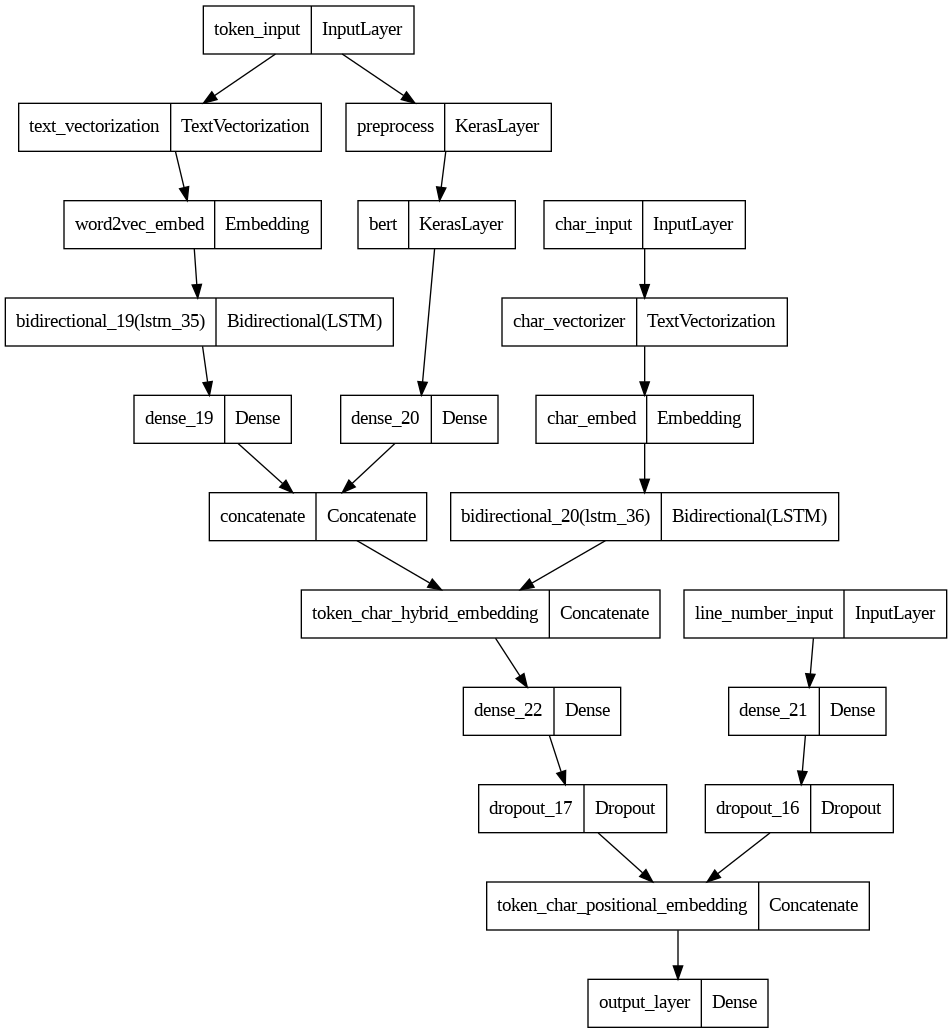

In [ ]:
# Plot the token, char, positional embedding model
plot_model(model_5)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Combine chars, tokens, and postional data into a dataset -- > batch --> prefetch
combined_train = tf.data.Dataset.from_tensor_slices(((train_position, train_text, train_chars), train_target)).batch(32).prefetch(tf.data.AUTOTUNE) 
combined_val = tf.data.Dataset.from_tensor_slices(((val_position, valid_text, val_chars), valid_target)).batch(32).prefetch(tf.data.AUTOTUNE)
combined_test = tf.data.Dataset.from_tensor_slices(((test_position, test_text, test_chars), test_target)).batch(32).prefetch(tf.data.AUTOTUNE)

combined_train, combined_val, combined_test

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 41), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [ ]:
# Reduce learning rate
callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr/3.2)
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(combined_train,
                              epochs=4,
                              validation_data=combined_val,
                              callbacks = [callback])

Epoch 1/4
5627/5627 [==============================] - 2369s 419ms/step - loss: 0.3665 - accuracy: 0.8677 - val_loss: 0.3321 - val_accuracy: 0.8749 - lr: 3.1250e-04
Epoch 2/4
5627/5627 [==============================] - 2353s 418ms/step - loss: 0.2921 - accuracy: 0.8924 - val_loss: 0.2855 - val_accuracy: 0.8936 - lr: 9.7656e-05
Epoch 3/4
5627/5627 [==============================] - 2353s 418ms/step - loss: 0.2771 - accuracy: 0.8976 - val_loss: 0.2748 - val_accuracy: 0.8984 - lr: 3.0518e-05
Epoch 4/4
5627/5627 [==============================] - 2354s 418ms/step - loss: 0.2720 - accuracy: 0.8993 - val_loss: 0.2705 - val_accuracy: 0.9000 - lr: 9.5367e-06


In [ ]:
# Save  the model
model_5.save('model_5')

In [ ]:
# Copy the model to drive
%cp -av "/content/model_5" "/content/drive/MyDrive/Tensorflow"

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Tensorflow/model_5')

In [ ]:
# Evaluate model 5 on test data
test_pred_probs = loaded_model.predict(combined_test)
test_preds = tf.argmax(test_pred_probs,1)
model_5_results = calculate_results(test_labels, test_preds)
print(model_5_results)
print(classification_report(test_labels, test_preds))

942/942 [==============================] - 327s 345ms/step
{'accuracy': 89.36452629832421, 'precision': 0.8943190503592543, 'recall': 0.8936452629832421, 'f1': 0.8912810934376262}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9897
           1       0.93      0.92      0.92      9713
           2       0.92      0.90      0.91      4571
           3       0.74      0.87      0.80      3621
           4       0.80      0.54      0.65      2333

    accuracy                           0.89     30135
   macro avg       0.86      0.84      0.84     30135
weighted avg       0.89      0.89      0.89     30135



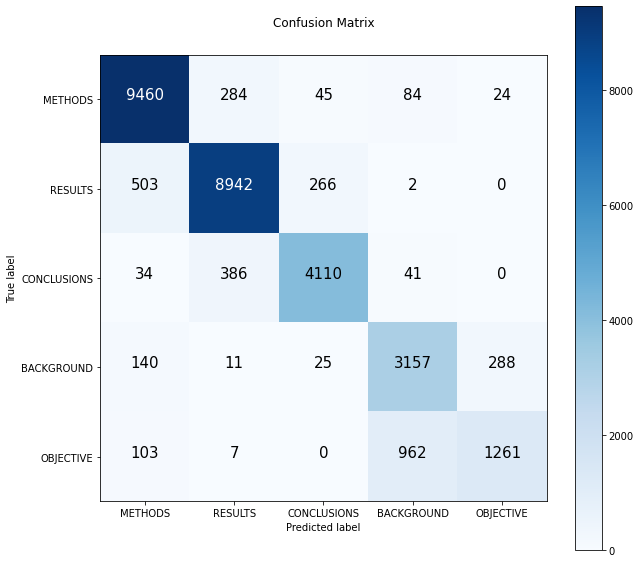

In [ ]:
# Make confusion matrix
make_confusion_matrix(test_labels, test_preds, classes = class_names)

### Error analysis

In [ ]:
# Add prediction class, probabilities to the dataframe
target_inverse_map = {value:key for key, value in target_map.items()}
test_data['target_pred'] = test_preds
test_data['target_pred'] = test_data['target_pred'].replace(target_inverse_map)
test_data['target_pred_conf'] = test_data_conf = np.max(test_pred_probs, axis = 1)
test_data['correct_pred'] = test_data['target_pred']==test_data['target']
pred_prob_cols = [i+'_prob' for i in class_names]
test_data[pred_prob_cols] = test_pred_probs
test_data['text_len'] = test_data['text'].str.len()
test_data['word_count']=[len(sentence.split()) for sentence in test_data.text.values]

In [ ]:
# check out the errors where an objective sentence is predicted as a background sentence
error_subset = test_data[(test_data['target']=='OBJECTIVE')&(test_data['target_pred']=='BACKGROUND')]
error_subset = error_subset.sort_values('target_pred_conf')
print(error_subset.shape)
error_subset.head()

(955, 14)


,line_number,target,text,total_lines,line_pos,target_pred,METHODS_prob,RESULTS_prob,CONCLUSIONS_prob,BACKGROUND_prob,OBJECTIVE_prob,target_pred_conf,text_len,word_count
25709,3,OBJECTIVE,the authors examined abcb@ genetic variants as...,13,0.230769,BACKGROUND,0.317313,0.012232,0.001174,0.349835,0.319445,0.349835,159,24
7054,2,OBJECTIVE,we examined whether baseline echocardiographic...,13,0.153846,BACKGROUND,0.260512,0.014929,0.000273,0.378414,0.345873,0.378414,169,21
4148,2,OBJECTIVE,we therefore compared systemic glucose turnove...,13,0.153846,BACKGROUND,0.378802,0.009359,0.000087,0.394865,0.216887,0.394865,358,58
6156,6,OBJECTIVE,"in the present study , the authors assessed th...",17,0.352941,BACKGROUND,0.194116,0.066721,0.191810,0.412133,0.135219,0.412133,101,17
10676,1,OBJECTIVE,these molecules are denoted as adipose tissue ...,13,0.076923,BACKGROUND,0.328813,0.003771,0.000069,0.416247,0.251101,0.416247,284,52


In [ ]:
# describe column statistics for error subset
error_subset.describe()

,line_number,total_lines,line_pos,METHODS_prob,RESULTS_prob,CONCLUSIONS_prob,BACKGROUND_prob,OBJECTIVE_prob,target_pred_conf,text_len,word_count
count,955.000000,955.000000,955.000000,955.000000,9.550000e+02,955.000000,955.000000,955.000000,955.000000,955.000000,955.000000
mean,0.807330,13.330890,0.061100,0.014620,1.806652e-03,0.002271,0.686527,0.294775,0.686527,150.324607,23.659686
std,0.969422,2.978511,0.072609,0.044278,1.157238e-02,0.014753,0.103941,0.094945,0.103941,62.255083,9.859942
min,0.000000,6.000000,0.000000,0.000005,2.180554e-07,0.000008,0.349835,0.061473,0.349835,44.000000,6.000000
25%,0.000000,11.000000,0.000000,0.000145,3.517568e-05,0.000103,0.613193,0.223466,0.613193,105.000000,17.000000
50%,1.000000,13.000000,0.055556,0.000888,9.667440e-05,0.000173,0.699551,0.287235,0.699551,141.000000,22.000000
75%,1.000000,15.000000,0.100000,0.005897,4.034683e-04,0.000373,0.766960,0.361044,0.766960,178.500000,29.000000
max,6.000000,23.000000,0.375000,0.406938,2.267940e-01,0.224889,0.918908,0.497634,0.918908,488.000000,74.000000


In [ ]:
for i, text in enumerate(error_subset['text'].values[:15]):
  print(i,')', text, '\n')

0 ) the authors examined abcb@ genetic variants as predictors of remission and side effects in a large clinical trial that also incorporated cognitive assessment . 

1 ) we examined whether baseline echocardiographic and clinical characteristics could identify those who will develop moderate/severe recurrent mitral regurgitation or die . 

2 ) we therefore compared systemic glucose turnover , including lactate gluconeogenesis ( gn ) and muscle glucose uptake , in individuals with type @ diabetes who were transplant recipients with partial graft function ( t@dm/itx ( + ) ) , matched non-transplanted individuals with type @ diabetes ( t@dm/itx ( - ) ) and matched healthy non-diabetic individuals . 

3 ) in the present study , the authors assessed the efficacy of g-suit for vasovagal syncope prevention . 

4 ) these molecules are denoted as adipose tissue generated mediators of cardiovascular risk ( atgmcvr ) here , and include leptin , adiponectin , c-reactive protein ( crp ) , interleuk

In [ ]:
test_data[['correct_pred','target']].groupby('target').agg(['count','mean']).sort_values([('correct_pred', 'count')])

correct_pred          
                   count      mean
target                            
OBJECTIVE           2333  0.541363
BACKGROUND          3621  0.864402
CONCLUSIONS         4571  0.895428
RESULTS             9713  0.918151
METHODS             9897  0.957967

 The main of the reasons we are not able to learn objective sentences is the class imbalance. The accuracy by classes are proportional to the class weight as shown above. 

# Compare and Visualise Experiment Results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,73.492617,0.727598,0.734926,0.726189
custom_token_embed,87.808196,0.878558,0.878082,0.875809
pretrained_token_embed,88.687573,0.893169,0.886876,0.882646
custom_char_embed_conv1d,73.047951,0.730756,0.730480,0.723507
hybrid_char_token_embed,84.449975,0.844309,0.844500,0.841913
tribrid_pos_char_token_embed,89.364526,0.894319,0.893645,0.891281


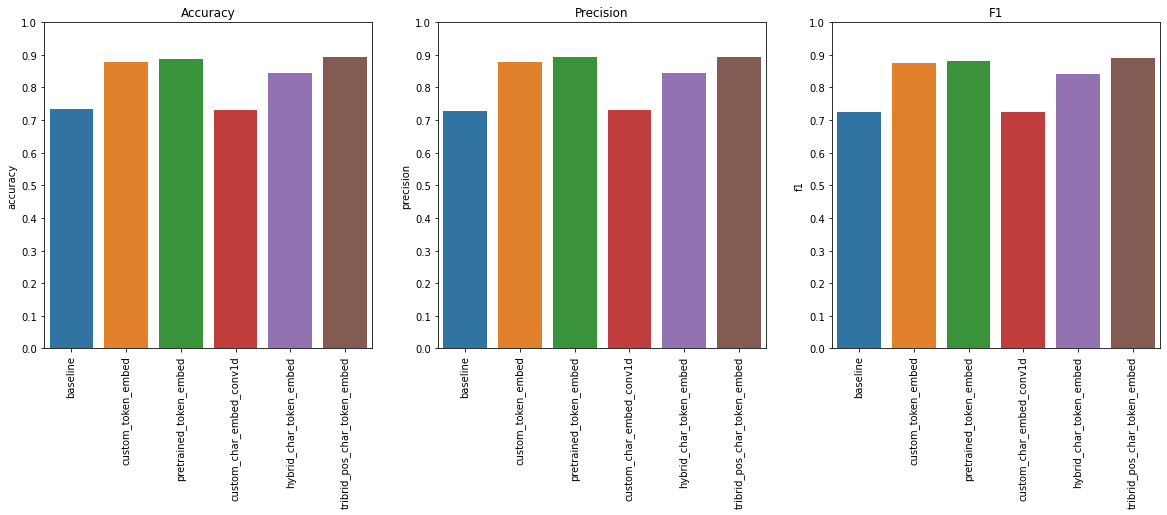

In [ ]:
plt.figure(figsize = (20,6))
all_model_results['accuracy']/=100 # Scale accuracy to [0,1] interval
for i, metric in enumerate(['accuracy', 'precision', 'f1']):
  plt.subplot(1,3,i+1)
  ax = sns.barplot(data = all_model_results, y = metric, x = all_model_results.index)
  plt.xticks(rotation = 90)
  plt.yticks(np.linspace(0,1,11))
  plt.title(metric.capitalize())
plt.show()

# Classify Abstract Sentences with the Final Model

In [ ]:
sample_abstract = 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.\
 Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and \
 therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation\
  of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills \
  acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent \
  ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) \
  corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, \
  along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the\
   medium and large ranges and favored the treatment group.'

sentences = sample_abstract.split('.')
for i, sentence in enumerate(sentences):
  print(i, sentence)

0 This RCT examined the efficacy of a manualized social intervention for children with HFASDs
1  Participants were randomly assigned to treatment or wait-list conditions
2  Treatment included instruction and  therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation  of non-literal language
3  A response-cost program was applied to reduce problem behaviors and foster skills   acquisition
4  Significant treatment effects were found for five of seven primary outcome measures (parent   ratings and direct child measures)
5  Secondary measures based on staff ratings (treatment group only)   corroborated gains reported by parents
6  High levels of parent, child and staff satisfaction were reported,   along with high levels of treatment fidelity
7  Standardized effect size estimates were primarily in the   medium and large ranges and favored the treatment group
8 


In [ ]:
# Splitting at '.' is may cause problems in some cases, e.g., www.pubmed.com would be split into 3 sentences.
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(sample_abstract) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
class bcolors: # This will allow us to print different categories in different colors
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    BOLD = '\033[1m'
target_color = {'OBJECTIVE': bcolors.BOLD, 'BACKGROUND':bcolors.HEADER, 'METHODS':bcolors.OKBLUE, 'CONCLUSIONS':bcolors.FAIL, 'RESULTS':bcolors.OKGREEN}

def score_function(model, nlp, abstract):
  """
  Predicts and prints the sentence category of the abstract sentences.
  Args:
    abstract: medical RCT paper abstract (str)
    model: tensorflow classification model (tf.keras.Model)
    nlp: english sentence parser
  Retuns:
    predictions: list of predicted classes (list)
  """
  def prepare_data(abstract): # preprocess the data into the same format as model input
    def split_chars(text):  # helper function for character tokenization
      return " ".join(list(text))
    
    doc = nlp(abstract) # create "doc" of parsed sequences, change index for a different abstract
    sentences = [str(sent) for sent in list(doc.sents)] # split into sentences using pipeline object
    total_lines = len(sentences)  # find the total number of sentences in the abstract
    line_nums = np.arange(total_lines)  # find the line number of each sentence
    line_nums_onehot = tf.one_hot(np.arange(total_lines),depth = 20)  # convert the line numbers to one-hot encoded format
    total_lines_onehot = tf.one_hot([total_lines]*len(sentences), depth = 20) # create one-hot encoded total_lines tensor
    line_relative_pos = line_nums / total_lines # find the relative position of sentences
    positional_data = tf.concat([line_nums_onehot, total_lines_onehot, np.array(line_relative_pos)[...,None]], axis = 1)  # concatenate positional data
    char_sentences = [split_chars(sentence) for sentence in sentences] # get character tokenized list of sentences
    inputs = (positional_data, np.array(sentences), np.array(char_sentences)) # combine text, char_text, positional data into a tuple
    return sentences, inputs 
  sentences, data = prepare_data(abstract)
  predictions = model.predict(data)
  predictions = tf.argmax(predictions, axis = 1).numpy()
  target_inverse_map = {0: 'METHODS', 1: 'RESULTS', 2: 'CONCLUSIONS', 3: 'BACKGROUND', 4: 'OBJECTIVE'} # convert numerical labels to class names
  predictions = [target_inverse_map[pred] for pred in predictions]
  for row, sentence in enumerate(sentences):
    print(target_color[predictions[row]], row, predictions[row],'\n', sentence,'\n\n')
  return predictions


In [ ]:
# Check the function on sample abstract
predictions = score_function(model_5, nlp, sample_abstract)

1/1 [==============================] - 0s 53ms/step
 0 OBJECTIVE 
 This RCT examined the efficacy of a manualized social intervention for children with HFASDs 


 1 METHODS 
  Participants were randomly assigned to treatment or wait-list conditions 


 2 METHODS 
  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language 


 3 METHODS 
  A response-cost program was applied to reduce problem behaviors and foster skills acquisition 


 4 RESULTS 
  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures) 


 5 RESULTS 
  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents 


 6 RESULTS 
  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity 


 7 RESULTS 
  Standardized effect size estimates were 